Détail sur le cadre du Cross Validation :
Nous allons nous plonger sur les raisons pour lesquelles il est toujours nécessaire de disposer d'ensembles de formation et de test. Examinons d'abord les limites de l'utilisation d'un ensemble de données sans conserver aucun échantillon.
Dans cet ensemble de données, l'objectif est de prédire la valeur médiane des maisons dans une zone de Californie. Les fonctionnalités collectées sont basées sur des informations immobilières et géographiques générales.

La cible à prédire est une variable continue (et non plus discrète vue dans le module 1). Cette tâche est appelée régression.

Pour cela, nous utiliserons un modèle prédictif spécifique à la régression et non à la classification.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [2]:
#Affichage de la description et documentation de l'ensemble des données
print(housing.DESCR)
data.head()

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
#Pour simplifier la visualisation future, transformons les prix de la fourchette de 100 (k$) à la fourchette de mille dollars (k$).
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64


**Erreur de formation vs erreur de test**

In [4]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

In [5]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")
#MAE donne l'erreur en K$.

On average, our regressor makes an error of 0.00 k$


La prédiction est un peu trop parfaite et cela laisse penser à du sur ajustement de notre modèle de prédiction. Cette erreur calculée ci-dessus est appelée erreur empirique ou erreur d’entraînement ou encore  erreur de généralisation ou « vraie » erreur de test.


Ainsi, l’évaluation la plus élémentaire implique :

-diviser notre ensemble de données en deux sous-ensembles : un ensemble de formation et un ensemble de tests ;
-ajuster le modèle sur l'ensemble d'entraînement ;
-estimer l'erreur de formation sur l'ensemble de formation ;

In [6]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


Nous observons les mêmes phénomènes que dans l'expérience précédente : notre modèle a mémorisé l'ensemble d'entraînement. Cependant, nous calculons maintenant l’erreur de test.

In [7]:
target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.28 k$


**Stabilité des estimations de validation croisée**

La validation croisée permet d'estimer la robustesse d'un modèle prédictif en répétant la procédure de fractionnement. Il donnera plusieurs erreurs de formation et de test et donc une estimation de la variabilité des performances de généralisation du modèle.

Il existe différentes stratégies de validation croisée, pour l'instant nous allons nous concentrer sur celle appelée "shuffle-split". À chaque itération de cette stratégie, nous :

mélanger aléatoirement l'ordre des échantillons d'une copie de l'ensemble de données complet ;
diviser l'ensemble de données mélangées en un train et un ensemble de test ;
former un nouveau modèle sur la rame ;
évaluer l’erreur de test sur l’ensemble de test.
Nous répétons cette procédure n_splits fois. Gardez à l'esprit que le coût de calcul augmente avec n_splits.

The mean cross-validated testing error is: 46.36 k$
The standard deviation of the testing error is: 1.17 k$
The standard deviation of the target is: 115.40 k$


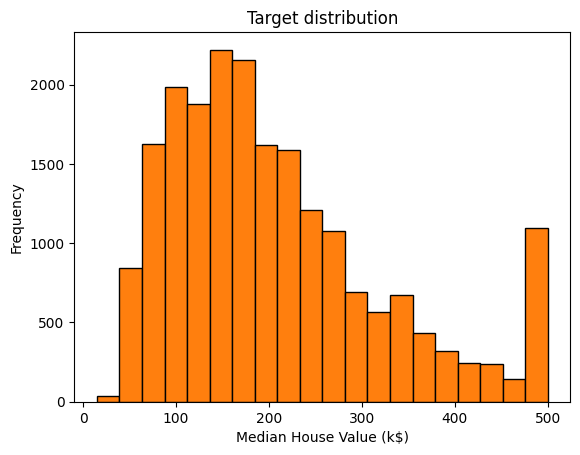

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error"
)
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

#Inversons la négation pour obtenir l'erreur réelle
cv_results["test_error"] = -cv_results["test_score"]
cv_results.head(10)
len(cv_results)
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")
print(
    "The mean cross-validated testing error is: "
    f"{cv_results['test_error'].mean():.2f} k$"
)
print(
    "The standard deviation of the testing error is: "
    f"{cv_results['test_error'].std():.2f} k$"
)
#Distribution de la variable cible
target.plot.hist(bins=20, edgecolor="black")
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")
print(f"The standard deviation of the target is: {target.std():.2f} k$")

La variable cible va de près de 0 k$ jusqu'à 500 k$ et, avec un écart type autour de 115 k$.

Nous remarquons que l'estimation moyenne de l'erreur de test obtenue par validation croisée est un peu plus petite que l'échelle naturelle de variation de la variable cible. De plus, l’écart type de l’estimation de validation croisée de l’erreur de test est encore plus petit.

C’est un bon début, mais pas nécessairement suffisant pour décider si les performances de généralisation sont suffisamment bonnes pour rendre notre prédiction utile en pratique.

Rappelons que notre modèle fait, en moyenne, une erreur de l'ordre de 47 k$. Avec ces informations et en regardant la distribution cible, une telle erreur pourrait être acceptable lors de la prévision de maisons d'une valeur de 500 k$. Cependant, ce serait un problème avec une maison d'une valeur de 50 k$. Ainsi, cela indique que notre métrique (Mean Absolute Error) n’est pas idéale.

Nous pourrions plutôt choisir une métrique relative à la valeur cible à prédire : le pourcentage d’erreur absolu moyen aurait été un bien meilleur choix.

Mais dans tous les cas, une erreur de 47 k$ peut être trop importante pour utiliser automatiquement notre modèle pour étiqueter les valeurs des maisons sans la supervision d'un expert.

**Plus de détails concernant cross_validate**

In [9]:
cv_results = cross_validate(regressor, data, target, return_estimator=True)
cv_results
cv_results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

Dans le cas où vous n'êtes intéressé que par le résultat du test, scikit-learn propose une fonction cross_val_score. Cela revient à appeler la fonction cross_validate et à sélectionner uniquement le test_score

In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])

OVERFIT- GENERALIZATION-UNDERFIT Comment les erreus de formation nous permettent de mettre en évidence une généralisation, une sur ou un sous ajustement de notre modèle

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

In [2]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

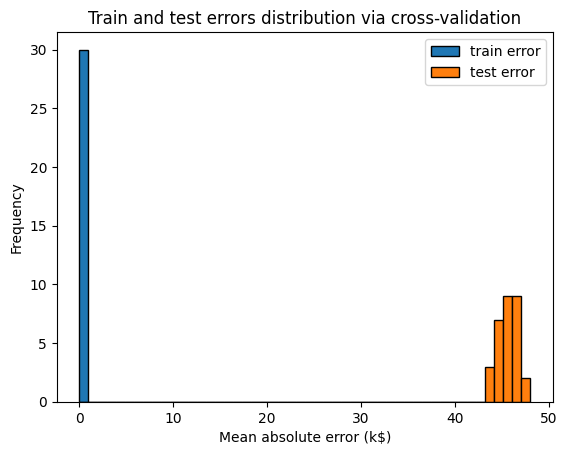

In [3]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
cv_results = cross_validate(
    regressor,
    data,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=2,
)
cv_results = pd.DataFrame(cv_results)

#La validation croisée a utilisé l’erreur absolue moyenne négative. Nous transformons l’erreur absolue moyenne négative en une erreur absolue moyenne positive.
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]
]
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

Ici, nous observons une petite erreur d'entraînement (en fait nulle), ce qui signifie que le modèle n'est pas sous-ajusté : il est suffisamment flexible pour capturer toutes les variations présentes dans l'ensemble d'entraînement.

Cependant, l'erreur de test significativement plus importante nous indique que le modèle est sur-ajusté : le modèle a mémorisé de nombreuses variantes de l'ensemble d'apprentissage qui pourraient être considérées comme « bruyantes » car elles ne se généralisent pas pour nous aider à faire de bonnes prédictions sur l'ensemble de test.

**VALIDATION CURVE **

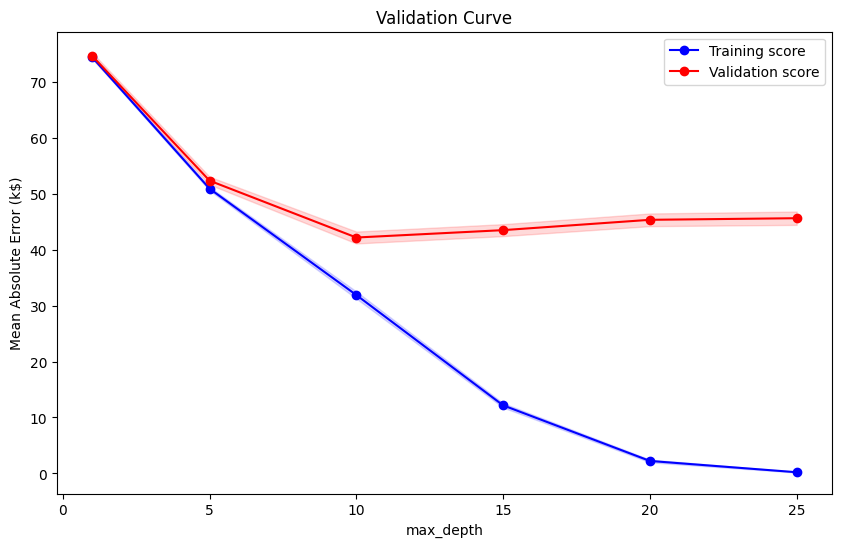

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

# Créez votre modèle (remplacez DecisionTreeRegressor par le modèle que vous utilisez)
regressor = DecisionTreeRegressor()

# Paramètre à valider (par exemple, max_depth pour un arbre de décision)
param_name = "max_depth"
param_range = np.array([1, 5, 10, 15, 20, 25])

# Utilisez validation_curve pour obtenir les scores d'entraînement et de validation
train_scores, valid_scores = validation_curve(
    regressor,
    data,
    target,
    param_name=param_name,
    param_range=param_range,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)

# Calculez les moyennes et les écarts types des scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Affichez la courbe de validation
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(
    param_range,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.15,
    color="blue",
)
plt.plot(param_range, valid_mean, label="Validation score", color="red", marker="o")
plt.fill_between(
    param_range,
    valid_mean - valid_std,
    valid_mean + valid_std,
    alpha=0.15,
    color="red",
)

plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Mean Absolute Error (k$)")
plt.legend(loc="best")
plt.show()

La courbe de validation peut être divisée en trois zones :

Pour max_degree < 10, l'arbre de décision est sous-adapté. L'erreur de formation et donc l'erreur de test sont toutes deux élevées. Le modèle est trop contraint et ne peut pas capturer une grande partie de la variabilité de la variable cible.

La région autour de max_degree = 10 correspond au paramètre pour lequel l'arbre de décision généralise le mieux. Il est suffisamment flexible pour capturer une fraction de la variabilité de la cible qui se généralise, sans mémoriser tout le bruit de la cible.

Pour max_degree > 10, l’arbre de décision est surajusté. L'erreur de formation devient très faible, tandis que l'erreur de test augmente. Dans cette région, les modèles créent des décisions spécifiquement pour les échantillons bruyants, ce qui nuit à leur capacité à généraliser pour tester les données.

Notez que pour max_degree = 10, le modèle surajuste un peu car il existe un écart entre l'erreur d'entraînement et l'erreur de test. Il peut également potentiellement être légèrement sous-ajusté en même temps, car l'erreur d'entraînement est encore loin d'être nulle (plus de 30 k$), ce qui signifie que le modèle pourrait encore être trop contraint pour modéliser des parties intéressantes des données. Cependant, l’erreur de test est minime, et c’est ce qui compte vraiment. C’est le meilleur compromis que l’on puisse atteindre en réglant simplement ce paramètre.

Sachez que regarder les erreurs moyennes est assez limitatif. Il faut également regarder l'écart type pour évaluer la dispersion du score.

**Effet de la taille de l'échantillon en validation croisée**

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

In [2]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

Courbe d'apprentissage lorsque l'on fait varier le nombre d'échantillon de formation

In [3]:
import numpy as np

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)

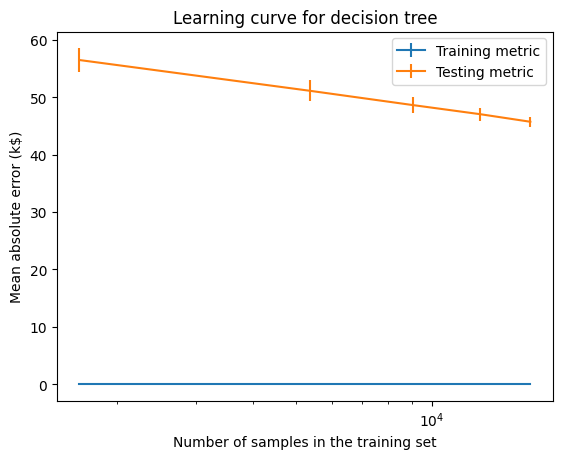

In [4]:
from sklearn.model_selection import LearningCurveDisplay

display = LearningCurveDisplay.from_estimator(
    regressor,
    data,
    target,
    train_sizes=train_sizes,
    cv=cv,
    score_type="both",  # both train and test errors
    scoring="neg_mean_absolute_error",
    negate_score=True,  # to use when metric starts with "neg_"
    score_name="Mean absolute error (k$)",
    std_display_style="errorbar",
    n_jobs=2,
)
_ = display.ax_.set(xscale="log", title="Learning curve for decision tree")

En regardant uniquement l'erreur d'entraînement, nous voyons que nous obtenons une erreur de 0 k$. Cela signifie que le modèle formé (c'est-à-dire l'arbre de décision) surajuste clairement les données de formation.

En regardant uniquement l’erreur de test, nous observons que plus d’échantillons sont ajoutés à l’ensemble d’apprentissage, plus l’erreur de test devient faible. En outre, nous recherchons le plateau de l'erreur de test pour lequel il n'y a plus d'avantage à ajouter des échantillons ou évaluons le gain potentiel de l'ajout de plus d'échantillons dans l'ensemble d'apprentissage.

Si nous atteignons un plateau et que l'ajout de nouveaux échantillons dans l'ensemble d'apprentissage ne réduit pas l'erreur de test, nous aurions peut-être atteint le taux d'erreur de Bayes en utilisant le modèle disponible. L’utilisation d’un modèle plus complexe pourrait être la seule possibilité de réduire davantage l’erreur de test.